![ine-divider](https://user-images.githubusercontent.com/7065401/92672068-398e8080-f2ee-11ea-82d6-ad53f7feb5c0.png)
<hr>

### Software Development with Python
# Using timeit to guide code speedups

This project lets you speed up code by using accurate timing of existing code, and comparing times as you make changes.

In this project, you will be work with a version of the Fractal software library this course uses throughout to demonstrate various Python software development tools.  This same library is used for other purposes in other INE courses.  The version of the library you will need for these exercises is at:

> https://github.com/ine-rmotr-projects/INE-Fractal/tree/softwaredev

Other branches of that repository will contain somewhat different versions of the library, and many projects in this course will not make sense in relation to them.

![orange-divider](https://user-images.githubusercontent.com/7065401/92672455-187a5f80-f2ef-11ea-890c-40be9474f7b7.png)

## Project

**Speed up `make_canvas(fractal.mandelbrot())`**

In this course, the videos made passing reference to the fact that the library Numba can often speedup numeric computation.  You are very unlikely to do better than Numba does for this problem.  However, your task is to utilize **different** refactoring techniques to make the rendering a Mandelbrot fractal faster, but still product the same results.  You may define for yourself what "the same" means.  That is, since the Mandelbrot set is actually the limit of infinitely many iterations, it is *possible* that a pixel or two may wind up with a different value in your alternate approach to finite iteration.  But most should be the same.

For this task, use the `timeit` module iteratively to see if your refactoring is successful in speeding up the needed computation.

In [1]:
import sys
# Substitute appropriate path for your repo clone
sys.path.append('/home/dmertz/git/INE-Fractal')

In [2]:
from fractal.mandelbrot import mandelbrot, fast_mandelbrot
from fractal.visualize import make_canvas, visualize

As an example of different speeds:

In [3]:
%timeit make_canvas(mandelbrot, -0.5, 0, 2, pixels=800)
%timeit make_canvas(fast_mandelbrot, -0.5, 0, 2, pixels=800)

8.43 s ± 135 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.12 s ± 41.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


A reasonable test of "same result" might be similar to this:

In [4]:
m1 = make_canvas(mandelbrot, -0.5, 0, 2, pixels=100)
m2 = make_canvas(fast_mandelbrot, -0.5, 0, 2, pixels=100)

same_pixels = (m1 == m2).sum() / m1.size
same_pixels > 0.999

True

**A possible solution**

This course briefly discussed that we might get a small gain by avoiding the huge number of calls to `abs()` on complex numbers.  However, a faster approach is to use NumPy more.


In [5]:
import numpy as np
from itertools import product

def make_canvas(fn, x, y, size, pixels, kws={}):
    """Create a 'canvas' based on an arbitrary function fn:ℂ🠖ℕ

    fn:     function visualized
    x:      real coordinate of center
    y:      imaginary coordinate of center
    size:   numeric range of value to plot in each coord
    pixels: size of generated graph in pixels (square)

    Canvas is NumPy array of dtype uint8 (0 <= n <= 255)
    """
    xspan, yspan = pixels, pixels
    canvas = np.empty(shape=(xspan, yspan), dtype=np.uint8)
    
    # Compute mandelbrot as whole canvas, not point-by-point
    if fn.__name__ == 'mandelbrot':
        return numpy_mandelbrot(canvas, x, y, size)
    
    for row, col in product(range(xspan), range(yspan)):
        real = x - (size/2) + (size * col/xspan)
        imag = y - (size/2) + (size * row/yspan)
        z0 = complex(real, imag)
        escape = fn(z0, **kws) or 0
        canvas[row, col] = escape
    return canvas

In [6]:
def numpy_mandelbrot(canvas, x, y, size):
    xspan, yspan = canvas.shape
    canvas[:] = 0
    z = np.empty(shape=canvas.shape, dtype=complex)
    for row, col in product(range(xspan), range(yspan)):
        real = x - (size/2) + (size * col/xspan)
        imag = y - (size/2) + (size * row/yspan)
        z[row, col] = complex(real, imag)
    init = z.copy()
        
    # Mayny points overflow, suppress warnings temporarily
    with np.warnings.catch_warnings():
        np.warnings.simplefilter("ignore")
        for orbit in range(256):
            z = np.square(z) + init
            canvas[(abs(z) < 2.0)] = orbit

    return canvas

In [7]:
%timeit make_canvas(mandelbrot, -0.5, 0, 2, pixels=800)

2.8 s ± 20.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


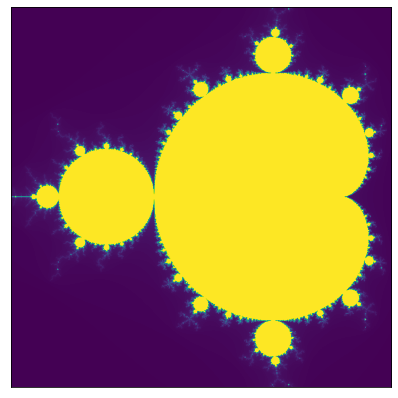

In [8]:
visualize(make_canvas(mandelbrot, -0.5, 0, 2, pixels=800))

![orange-divider](https://user-images.githubusercontent.com/7065401/92672455-187a5f80-f2ef-11ea-890c-40be9474f7b7.png)